In [1]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListTusz
from lib.signals import EegProcessorTusz
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.stats import StatisticalTests
from lib.bss import IWasobi, EogDenoiser, CanonicalCorrelation, EmgDenoiser
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### * Scales the EEG signal
### * Select a subset of the channels

{
    "cpsz": 279,
    "fnsz": 1549,
    "gnsz": 444,
    "tcsz": 30,
    "absz": 50,
    "mysz": 2,
    "tnsz": 18,
    "spsz": 49
}
{'full_file': '/mnt/c/Users/tobit/Downloads/eeg_datasets/tusz/edf/train/aaaaaenl/s001_2006/02_tcp_le/aaaaaenl_s001_t001.edf', 'seizures': [(0.0, 0.0, 'bckg'), [112.012, 128.46, 'absz']]}
Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/tusz/edf/train/aaaaaenl/s001_2006/02_tcp_le/aaaaaenl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-03-17 20:22:38,578 - root - INFO - Recording contains channels = ['EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE', 'EEG C4-LE', 'EEG A1-LE', 'EEG A2-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE', 'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE', 'EEG OZ-LE', 'EEG PG1-LE', 'EEG PG2-LE', 'EEG EKG-LE', 'EEG 26-LE', 'EEG 27-LE', 'EEG 28-LE', 'EEG 29-LE', 

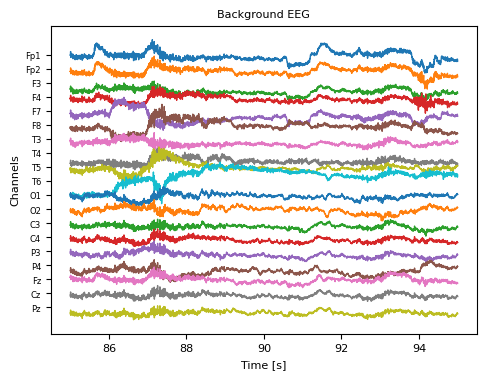

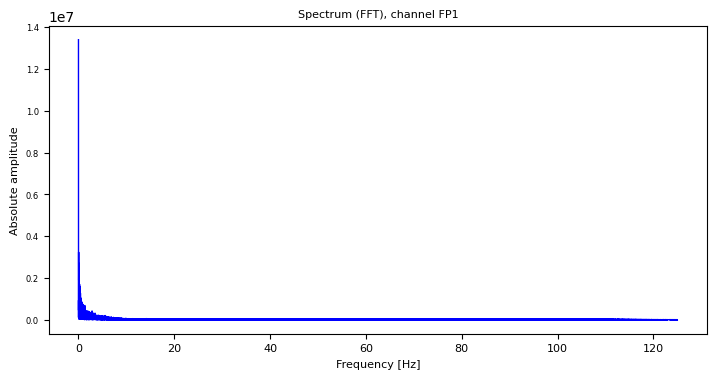

In [2]:
PATIENT = "aaaaaenl"
FILENAME = "aaaaaenl_s001_t001"
PERIOD = [85, 95]

###########################################################
metadata = MetadataListTusz()
metadata.summarize()
current_metadata = metadata.get(PATIENT, FILENAME)
print(current_metadata)
###########################################################
processor = EegProcessorTusz(current_metadata["full_file"])
processor.scale()
processor.select_channels()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

In [3]:
print(processor._data.shape)
print(processor.sampling_frequency)
print(current_metadata)

(19, 367750)
250.0
{'full_file': '/mnt/c/Users/tobit/Downloads/eeg_datasets/tusz/edf/train/aaaaaenl/s001_2006/02_tcp_le/aaaaaenl_s001_t001.edf', 'seizures': [(0.0, 0.0, 'bckg'), [112.012, 128.46, 'absz']]}


### * Re-referencing to average reference

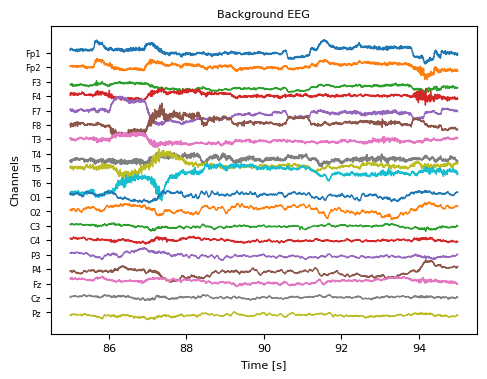

In [4]:
###########################################################
processor.rereference_to_average()

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Resample the EEG to 256Hz

2025-03-10 23:42:00,020 - root - INFO - Selected frequency is = 250
2025-03-10 23:42:00,025 - root - INFO - Dowsampling factor is = 1


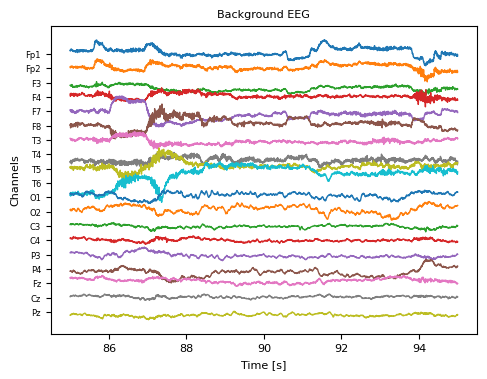

In [5]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)


### * Remove the drift noise, high frequency oscillations, power line noise

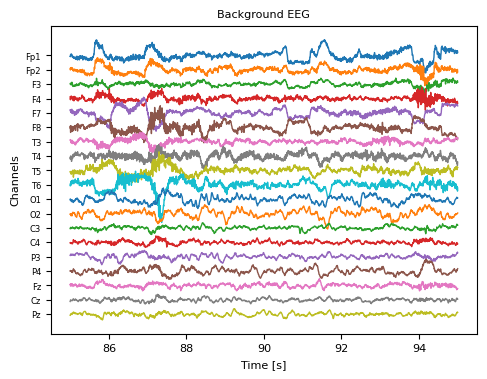

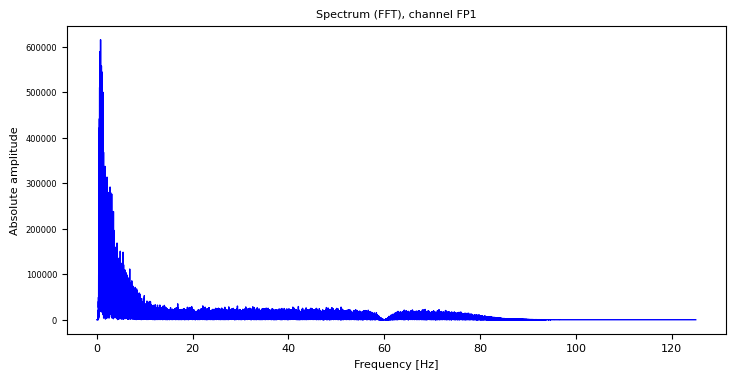

In [6]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

### * Separated sources using iWASOBI

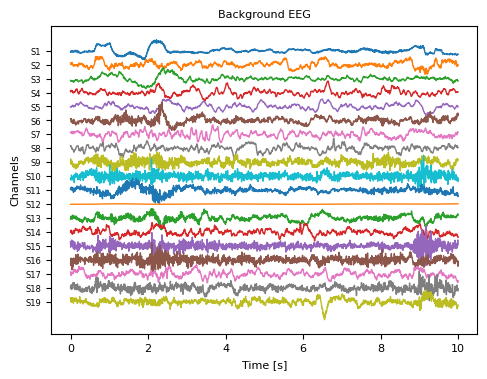

Source = 1, fd = 4.561446801765378
Source = 2, fd = 4.895702758728737
Source = 3, fd = 4.30197768431945
Source = 4, fd = 4.487052357009178
Source = 5, fd = 4.1841114987163355
Source = 6, fd = 5.581547841843775
Source = 7, fd = 4.765756762413986
Source = 8, fd = 4.692921119578291
Source = 9, fd = 6.141131565087809
Source = 10, fd = 6.327352795256742
Source = 11, fd = 5.652111400850313
Source = 12, fd = -0.4911238955898207
Source = 13, fd = 5.465546013282013
Source = 14, fd = 4.8639996878852445
Source = 15, fd = 6.264081517913752
Source = 16, fd = 6.35112983609354
Source = 17, fd = 4.962517797505738
Source = 18, fd = 5.95486316986081
Source = 19, fd = 5.616878049733541
Done!
2025-03-10 23:42:15,478 - root - INFO - Number of sources to be removed = 1


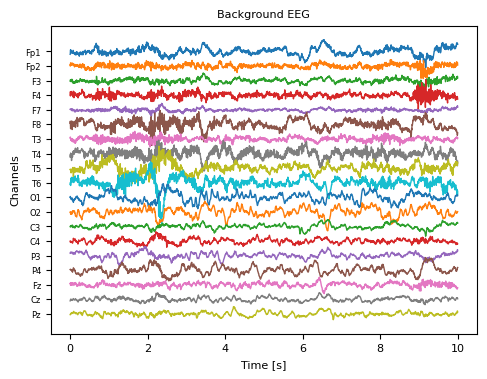

In [7]:
iwasobi = IWasobi()
eeg_sources = iwasobi.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                       PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eog_denoiser = EogDenoiser()
eog_denoiser.fit_fractal_dimensions(eeg_sources)
print(eog_denoiser)

eeg_sources = eog_denoiser.remove_low_dimension_sources([0, 3])

###########################################################
eeg_sources[0, :] = 0
eeg_sources[1, :] = 0
clean_eeg = iwasobi.inverse_transform(eeg_sources)

plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

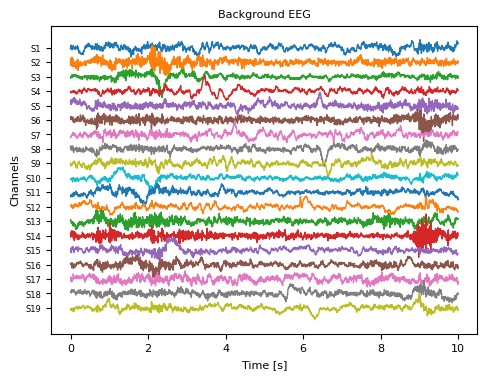

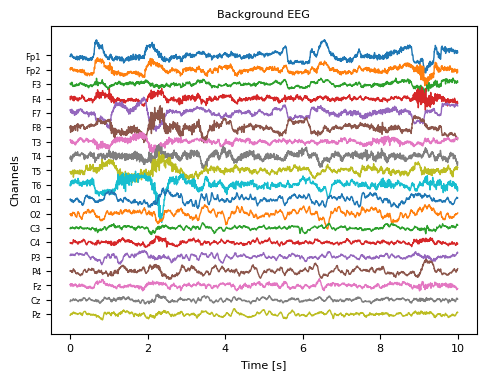

In [8]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
#eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using BSS Canonical Correlation Analysis

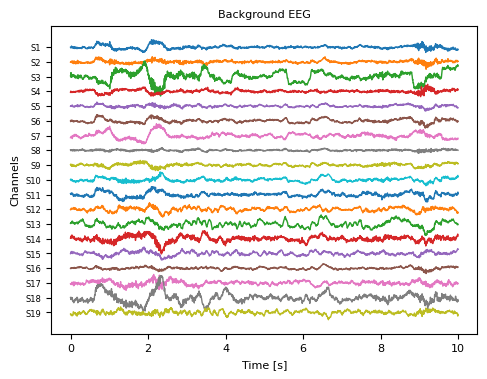

Source = 1, fd = 92.72257128979604
Source = 2, fd = 15.297071046042056
Source = 3, fd = 290.44739682795665
Source = 4, fd = 115.43666044621364
Source = 5, fd = 36.69157534572671
Source = 6, fd = 129.3934396355928
Source = 7, fd = 359.72943416336756
Source = 8, fd = 54.08713028374952
Source = 9, fd = 113.06737108224827
Source = 10, fd = 116.19987260742823
Source = 11, fd = 141.82652116640867
Source = 12, fd = 95.85794599039663
Source = 13, fd = 159.1786586592306
Source = 14, fd = 86.54498438216429
Source = 15, fd = 161.7566556588325
Source = 16, fd = 72.72134059444556
Source = 17, fd = 79.88396015092783
Source = 18, fd = 266.7247362831083
Source = 19, fd = 83.16854259015139
Done!
2025-03-10 23:42:37,932 - root - INFO - Number of sources to be removed = 0


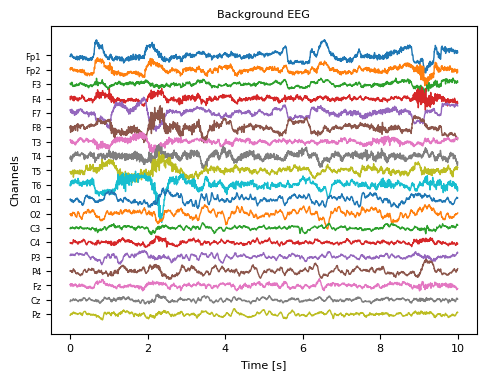

In [9]:
bsscca = CanonicalCorrelation()
eeg_sources = bsscca.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                      PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
emg_denoiser = EmgDenoiser(sampling_frequency=processor.sampling_frequency)
emg_denoiser.fit_psd_ratio(eeg_sources)
print(emg_denoiser)

eeg_sources = emg_denoiser.remove_low_ratio_sources([0, 3])

###########################################################
clean_eeg = bsscca.inverse_transform(eeg_sources)
plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Stationarity tests (KPPS and ADF)

In [10]:
stats_gateway = StatisticalTests()
stats_gateway.check_stationarity(processor._data[15, :4000])

2025-03-10 23:42:49,531 - root - INFO - KPSS test, null hyphotesis was not rejected, p_value = 0.1, significance level = 0.05
2025-03-10 23:42:49,542 - root - INFO - White test, null hyphotesis was rejected, p_value = 8.009925952329227e-59, significance level = 0.05
2025-03-10 23:42:49,545 - root - INFO - The series is trend stationary  (not strict stationarity)


/mnt/c/Users/tobit/Documents/Doctorado/Initiative1_epic1/Project/code/notebooks/../lib/stats.py:99: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  _, p_value, _, _ = stattools.kpss(time_serie, regression="c")


'Trend stationary'